In [1]:
import os
import argparse
import numpy as np
import tensorflow as tf
from epi.models import Parameter, Model
import time
import matplotlib.pyplot as plt
from epi.STG_Circuit import Simulate, NetworkFreq

In [2]:
# 1. Specify the V1 model for EPI.
D = 2
g_el = Parameter("g_el", 1, lb=0.01, ub=8.)
g_synA = Parameter("g_synA", 1, lb=0.01, ub=4.)

# Define model
name = "STG"
parameters = [g_el, g_synA]
model = Model(name, parameters)

In [3]:
dt = 0.025
T = 300
sigma_I = 5e-13
simulate = Simulate(dt, T, sigma_I)

In [4]:
lb = np.concatenate([p.lb for p in model.parameters], axis=0)
ub = np.concatenate([p.ub for p in model.parameters], axis=0)

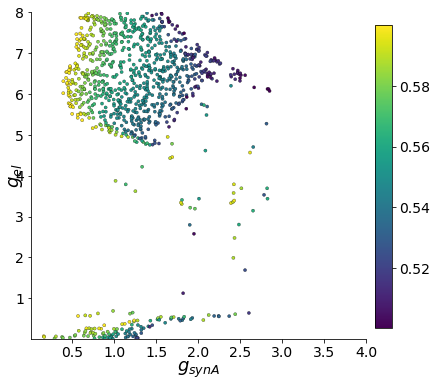

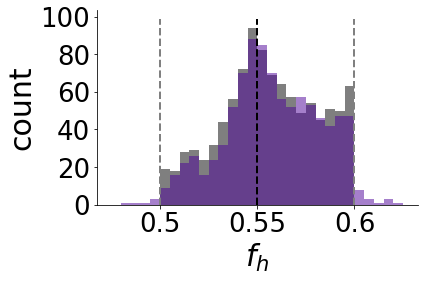

In [12]:
from epi.util import pairplot, plot_T_x
def accept_inds(T_x, mu, std):
    return np.logical_and(-2*std + mu < T_x[:,0], 
                          T_x[:,0] < mu + 2*std)

num_keep = 1000
num_plot = 1000
M = 1000
zs = []
T_xs = []

freqs = [0.55]
std = 0.025

for i,freq in enumerate(freqs):
    mu = np.array([freq])
    network_freq = NetworkFreq(dt, T, sigma_I, mu)
    model.set_eps(network_freq)
    fontsize = 30
    num_found = 0
    z = None
    T_x = None
    count = 0
    while (num_found < num_keep):
        count += 1
        _z = np.zeros((M, D))
        for d in range(D):
            _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
        _T_x = model.eps(_z).numpy()

        inds = accept_inds(_T_x, freq, std)
        _z = _z[inds, :]
        _T_x = _T_x[inds, :]
        num_found += _z.shape[0]

        if (z is None):
            z = _z
            T_x = _T_x
        else:
            z = np.concatenate((z, _z), axis=0)
            T_x = np.concatenate((T_x, _T_x), axis=0)
        print('%d %d/%d\r' % (count, num_found, num_keep), end='')

    num_found = z.shape[0]

    # reduce to num_keep
    z = z[:num_keep]
    T_x = T_x[:num_keep]
    
    z_labels = [r'$g_{el}$', r'$g_{synA}$']
    fig = pairplot(z[:num_plot], np.arange(2), z_labels, figsize=(6,6),
                   c=T_x[:,0],
                   fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
    #plt.savefig(figdir + name + '_z.png')

    T_x_sim = model.eps(z).numpy()

    plot_T_x(T_x[:,0], T_x_sim[:,0], x_mean=freq, x_std=std, xmin=freq-3*std, xmax=freq+3.*std, xlabel=r'$f_h$', fontsize=30)
    plt.tight_layout()
    #plt.savefig(figdir + name + '_Tx.png')


    zs.append(z)
    T_xs.append(T_x)

(-0.07, 0.0)

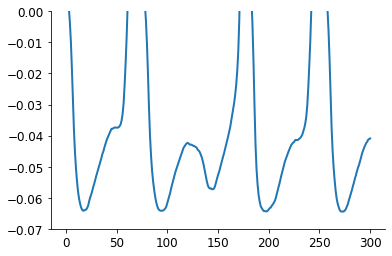

In [13]:
from epi.STG_Circuit import Simulate_all
g_el = 6.*np.ones((1,1))
g_synA = 2.*np.ones((1,1))
simulate = Simulate_all(dt, T, 5e-12)
x_t = simulate(g_el, g_synA)
plt.plot(x_t[:,2])
plt.ylim([-0.07, 0.])

(array([  1.,   1.,   1.,   5.,  10.,  32., 111., 355., 423.,  61.]),
 array([0.53673756, 0.537081  , 0.5374245 , 0.537768  , 0.53811145,
        0.5384549 , 0.5387984 , 0.5391419 , 0.53948534, 0.5398288 ,
        0.5401723 ], dtype=float32),
 <BarContainer object of 10 artists>)

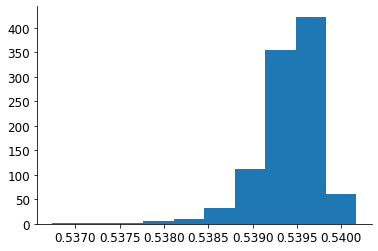

In [15]:
M = 1000
_sigma_I = 5e-13
g_el = 5.5*np.ones((M,1))
g_synA = 1.5*np.ones((M,1))
network_freq = NetworkFreq(dt, T, _sigma_I, mu)
T_x = network_freq(g_el, g_synA).numpy()
plt.hist(T_x[:,0])